In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
import model.dataset.game_matchup as ds_games_matchup
pd.options.display.max_columns = None
pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
from pandas_profiling import ProfileReport

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [3]:
games_matchup = ds_games_matchup.load_game_matchup_dataset()

In [4]:
df = games_matchup[games_matchup.SEASON >= 2008]

In [5]:
#profile = ProfileReport(games[games.SEASON>=2010], title='Pandas Profiling Report', explorative=True)
#profile

In [6]:
profile = ProfileReport(df, title='Pandas Profiling Report', pool_size=4,
                        #minimal=True,
                        explorative=True,
                           correlations={
             "pearson": {"calculate": False},
             "spearman": {"calculate": False},
             "kendall": {"calculate": False},
             "phi_k": {"calculate": False},
             "cramers": {"calculate": False},
         })

In [ ]:
profile

In [7]:
df[df.PTS_away > 140]

,GAME_DATE_EST,HOME_TEAM_NAME,HOME_TEAM_ID,VISITOR_TEAM_NAME,VISITOR_TEAM_ID,GAME_STATUS_TEXT,SEASON,HT_RANK,HT_CLASS,HT_HW,HT_HL,HT_VW,HT_VL,HT_LAST10_W,HT_LAST10_L,HT_LAST10_MATCHUP_W,HT_LAST10_MATCHUP_L,HT_OVERALL_OFF_POINTS,HT_OVERALL_DEF_POINTS,HT_OVERALL_OFF_FG,HT_OVERALL_DEF_FG,HT_OVERALL_OFF_3P,HT_OVERALL_DEF_3P,HT_OVERALL_OFF_FT,HT_OVERALL_DEF_FT,HT_OVERALL_OFF_REB,HT_OVERALL_DEF_REB,HT_AWAY_POINTS,HT_AWAY_FG,HT_AWAY_3P,HT_AWAY_FT,HT_AWAY_REB,VT_RANK,VT_CLASS,VT_HW,VT_HL,VT_VW,VT_VL,VT_LAST10_W,VT_LAST10_L,VT_LAST10_MATCHUP_W,VT_LAST10_MATCHUP_L,VT_OVERALL_OFF_POINTS,VT_OVERALL_DEF_POINTS,VT_OVERALL_OFF_FG,VT_OVERALL_DEF_FG,VT_OVERALL_OFF_3P,VT_OVERALL_DEF_3P,VT_OVERALL_OFF_FT,VT_OVERALL_DEF_FT,VT_OVERALL_OFF_REB,VT_OVERALL_DEF_REB,VT_AWAY_POINTS,VT_AWAY_FG,VT_AWAY_3P,VT_AWAY_FT,VT_AWAY_REB,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
GAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20800808,2009-02-18,LAC,1610612746,PHX,1610612756,Final,2008,2,0,6,20,7,21,3,7,3,7,94.574,102.815,0.435,0.464,0.337,0.363,0.750,0.767,40.259,44.389,96.964,0.442,0.352,0.770,40.536,17,1,15,10,14,13,5,5,7,3,105.077,103.385,0.498,0.452,0.385,0.367,0.757,0.769,41.904,40.308,102.519,0.487,0.361,0.765,39.852,119.0,0.477,0.667,0.478,27.0,35.0,142.0,0.589,0.800,0.476,34.0,47.0,0
20800994,2009-03-15,GSW,1610612744,PHX,1610612756,Final,2008,6,0,17,15,6,27,4,6,4,6,108.138,111.508,0.459,0.467,0.366,0.390,0.779,0.777,42.138,47.154,102.394,0.441,0.355,0.764,41.576,16,1,20,13,15,18,3,7,6,4,107.500,106.061,0.502,0.463,0.386,0.377,0.753,0.776,41.152,40.652,104.667,0.488,0.371,0.759,39.939,130.0,0.484,0.875,0.280,26.0,35.0,154.0,0.621,0.757,0.421,40.0,44.0,0
20801120,2009-04-01,GSW,1610612744,SAC,1610612758,Final,2008,6,0,19,17,6,32,3,7,6,4,108.608,112.486,0.460,0.471,0.369,0.384,0.786,0.778,41.892,47.027,102.684,0.441,0.359,0.769,41.500,0,0,11,26,5,31,2,8,4,6,100.397,108.630,0.451,0.485,0.361,0.398,0.801,0.760,38.603,43.644,98.194,0.453,0.366,0.816,36.583,143.0,0.535,0.762,0.231,25.0,52.0,141.0,0.439,0.827,0.480,22.0,49.0,1
20900034,2009-10-31,NYK,1610612752,PHI,1610612755,Final,2009,0,0,20,21,12,31,3,7,1,9,105.000,107.833,0.444,0.481,0.357,0.353,0.789,0.761,42.202,46.167,103.140,0.440,0.352,0.784,41.372,22,2,25,17,17,25,3,7,9,1,97.524,97.464,0.461,0.463,0.315,0.361,0.744,0.780,41.119,39.298,97.333,0.462,0.304,0.734,40.381,127.0,0.470,0.792,0.341,27.0,31.0,141.0,0.607,0.857,0.375,20.0,49.0,0
21300916,2014-03-06,LAL,1610612747,LAC,1610612746,Final,2013,4,0,10,19,11,21,3,7,4,6,101.557,106.869,0.451,0.458,0.380,0.338,0.750,0.719,41.656,48.689,100.750,0.442,0.390,0.751,41.375,23,2,25,5,17,15,8,2,6,4,107.177,100.677,0.474,0.444,0.346,0.322,0.731,0.750,42.903,43.984,103.656,0.467,0.356,0.713,41.344,94.0,0.395,0.692,0.267,26.0,33.0,142.0,0.553,0.727,0.462,34.0,64.0,0
21301161,2014-04-08,LAL,1610612747,HOU,1610612745,Final,2013,5,0,14,24,11,28,3,7,4,6,102.532,109.026,0.450,0.467,0.376,0.353,0.755,0.728,41.195,48.896,101.231,0.438,0.381,0.753,41.000,24,2,31,8,20,17,7,3,6,4,107.145,102.408,0.474,0.443,0.355,0.347,0.709,0.758,45.171,41.645,104.838,0.468,0.346,0.704,43.514,130.0,0.463,0.800,0.438,38.0,33.0,145.0,0.577,0.786,0.423,33.0,58.0,0
21401184,2015-04-10,DEN,1610612743,DAL,1610612742,Final,2014,6,0,18,21,11,28,3,7,6,4,100.333,104.013,0.432,0.457,0.326,0.336,0.730,0.747,44.410,45.231,97.949,0.429,0.312,0.721,43.308,21,2,26,14,21,17,4,6,4,6,104.590,101.718,0.463,0.451,0.346,0.363,0.757,0.749,42.051,46.064,102.684,0.452,0.348,0.758,42.158,143.0,0.424,0.880,0.349,29.0,61.0,144.0,0.523,0.792,0.379,39.0,49.0,0
21500391,2015-12-18,CHI,1610612741,DET,1610612765,Final,2015,24,2,11,3,4,5,6,4,5,5,98.826,96.913,0.426,0.412,0.365,0.321,0.749,0.716,48.696,47.783,100.778,0.435,0.397,0.755,45.667,17,1,10,4,5,8,7,3,5,5,100.074,98.370,0.427,0.455,0.330,0.344,0.675,0.752,47.148,44.111,95.308,0.412,0.301,0.651,45.923,144.0,0.417,0.886,0.227,21.0,62.0,147.0

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score

In [17]:
df = games_matchup[games_matchup.SEASON >= 2008]
models = []
#models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))) 
#models.append(('SVM', SVC(kernel = 'linear', random_state=0))) 
#models.append(('KSVM', SVC(kernel = 'rbf', random_state=0))) 
#models.append(('NB', GaussianNB())) 
models.append(('DT', DecisionTreeClassifier(criterion = 'entropy', random_state=0))) 
models.append(("RF", RandomForestClassifier(n_estimators=500, 
                                            max_features="sqrt", 
                                            max_depth=15, 
                                            n_jobs=-1, 
                                            random_state = 0)))
#models.append(("GB", GradientBoostingClassifier(n_estimators=500, 
#                                                max_depth=15, 
#                                                max_features="sqrt", 
#                                                random_state = 0)))

# Ensemble method - collection of many decision trees

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=len(df.SEASON.unique())-1, max_train_size=15)
    utils.X_y_values(df)

    cv_results = cross_validate(model,
                                 utils.X,
                                 utils.y.ravel(),
                                 cv=tscv,
                                 scoring=['balanced_accuracy', 'precision', "recall"])
    results.append(cv_results)
    names.append(name)
    
    print('%s %s: %f (%f)' % ('balanced_accuracy', name, cv_results["test_balanced_accuracy"].mean()
                              , cv_results["test_balanced_accuracy"].std()))
    print('%s %s: %f (%f)' % ("precision", name, cv_results["test_precision"].mean()
                               , cv_results["test_precision"].std()))
    print('%s %s: %f (%f)' % ("recall", name, cv_results["test_recall"].mean()
                               , cv_results["test_recall"].std()))
    
    #model.fit(X=utils.X_train,y=utils.y_train.ravel())
    #y_pred = model.predict(utils.X_test)
    #print("Balanced accuracy score: {:.2f}%".format(100 * balanced_accuracy_score(utils.y_test, y_pred)))
    #print("Precision: {:.2f}%".format(100 * precision_score(utils.y_test, y_pred)))
    #print("Recall: {:.2f}%".format(100 * recall_score(utils.y_test, y_pred)))
    #print("-------------------------------------------------")
    



balanced_accuracy DT: 0.621635 (0.070020)
precision DT: 0.707793 (0.072917)
recall DT: 0.638796 (0.132073)
balanced_accuracy RF: 0.591940 (0.048278)
precision RF: 0.655157 (0.042523)
recall RF: 0.797533 (0.141142)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fde34a46790>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdde2da48d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdde2daa910>,
 'medians': [<matplotlib.lines.Line2D at 0x7fdde2da33d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdde2da3910>,
 'means': []}

Text(0.5, 1.0, 'test_balanced_accuracy')

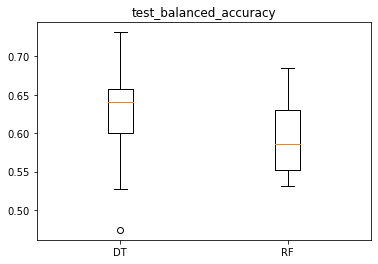

In [30]:
# Compare Algorithms\n",

plt.boxplot([results[0]["test_balanced_accuracy"], results[1]["test_balanced_accuracy"]], labels=names)
plt.title('test_balanced_accuracy')
plt.show()

In [28]:
len(results[0]["test_balanced_accuracy"])

10

In [12]:
#splits = np.arange(0, len(results[0]), 1)
from sklearn.metrics import SCORERS
sorted(SCORERS.keys()) 

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [ ]:
plt.plot(splits, results[0])
plt.show()

In [ ]:
plt.plot(splits, results[1])
plt.show()